### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from xgboost import to_graphviz, plot_importance

%matplotlib inline
sns.set_style('dark')
sns.set(font_scale=1.5)

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, mean_absolute_error, mean_squared_error,r2_score
from sklearn.metrics import plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, accuracy_score
from sklearn.metrics import auc, f1_score, precision_score, recall_score, roc_auc_score

import feature_engine.missing_data_imputers as mdi
from feature_engine.outlier_removers import Winsorizer

from tpot import TPOTClassifier, TPOTRegressor
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

import warnings
warnings.filterwarnings('ignore')

import pickle
from pickle import dump

pd.options.display.max_columns= None
#pd.options.display.max_rows = None

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py

### Data Exploration

In [2]:
df = pd.read_csv("Lemonade.csv")

In [3]:
df

,Date,Month,Day,Temperature,Rainfall,RainfallCategory,Flyers,FlyerSuccess,FlyerSuccessScore,Price,Sales,Target,MadeQuota,OverallPerformance,Revenue
0,1/1/2017,Jan,Sunday,27.0,2.00,Heavy,15,Low,5,0.3,10,8,0,5,3.0
1,2/1/2017,Jan,Monday,28.9,1.33,Heavy,15,Low,5,0.3,13,8,0,5,3.9
2,3/1/2017,Jan,Tuesday,34.5,1.33,Heavy,27,Medium,10,0.3,15,8,0,10,4.5
3,4/1/2017,Jan,Wednesday,44.1,1.05,Heavy,28,Medium,10,0.3,17,8,0,10,5.1
4,5/1/2017,Jan,Thursday,42.4,1.00,Medium,33,Medium,10,0.3,18,8,0,10,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
360,27/12/2017,Dec,Wednesday,42.7,0.00,None,33,Medium,10,0.3,19,8,0,10,5.7
361,28/12/2017,Dec,Thursday,37.8,0.00,None,32,Medium,10,0.3,16,8,0,10,4.8
362,29/12/2017,Dec,Friday,39.5,1.25,Heavy,17,Low,5,0.3,15,8,0,5,4.5
363,30/12/2017,Dec,Saturday,30.9,1.43,Heavy,22,Medium,10,0.3,13,8,0,10,3.9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                365 non-null    object 
 1   Month               365 non-null    object 
 2   Day                 365 non-null    object 
 3   Temperature         365 non-null    float64
 4   Rainfall            365 non-null    float64
 5   RainfallCategory    365 non-null    object 
 6   Flyers              365 non-null    int64  
 7   FlyerSuccess        365 non-null    object 
 8   FlyerSuccessScore   365 non-null    int64  
 9   Price               365 non-null    float64
 10  Sales               365 non-null    int64  
 11  Target              365 non-null    int64  
 12  MadeQuota           365 non-null    int64  
 13  OverallPerformance  365 non-null    int64  
 14  Revenue             365 non-null    float64
dtypes: float64(4), int64(6), object(5)
memory usage: 42.9+ KB

In [5]:
df.describe(include='all')

,Date,Month,Day,Temperature,Rainfall,RainfallCategory,Flyers,FlyerSuccess,FlyerSuccessScore,Price,Sales,Target,MadeQuota,OverallPerformance,Revenue
count,365,365,365,365.000000,365.000000,365,365.000000,365,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000
unique,365,12,7,NaN,NaN,3,NaN,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,25/6/2017,Mar,Sunday,NaN,NaN,Medium,NaN,Medium,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,31,53,NaN,NaN,165,NaN,174,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,60.731233,0.520849,NaN,40.284932,NaN,12.095890,0.333973,25.323288,8.0,4.219178,16.315068,8.722466
std,NaN,NaN,NaN,16.196266,0.490522,NaN,13.178651,NaN,2.951831,0.075206,6.893589,0.0,4.945435,6.957241,4.017536
min,NaN,NaN,NaN,15.100000,0.000000,NaN,9.000000,NaN,5.000000,0.300000,7.000000,8.0,0.000000,5.000000,2.100000
25%,NaN,NaN,NaN,49.700000,0.000000,NaN,31.000000,NaN,10.000000,0.300000,20.000000,8.0,0.000000,10.000000,6.000000
50%,NaN,NaN,NaN,61.100000,0.710000,NaN,39.000000,NaN,10.000000,0.300000,25.000000,8.0,0.000000,15.000000,7.500000
75%,NaN,NaN,NaN,71.300000,0.870000,NaN,49.000000,NaN,15.000000,0.300000,30.000000,8.0,10.000000,25.000000,9.300000


In [6]:
df.shape

(365, 15)

In [7]:
df.columns

Index(['Date', 'Month', 'Day', 'Temperature', 'Rainfall', 'RainfallCategory',
       'Flyers', 'FlyerSuccess', 'FlyerSuccessScore', 'Price', 'Sales',
       'Target', 'MadeQuota', 'OverallPerformance', 'Revenue'],
      dtype='object')

### Data Visualization

### Univariate Data Exploration

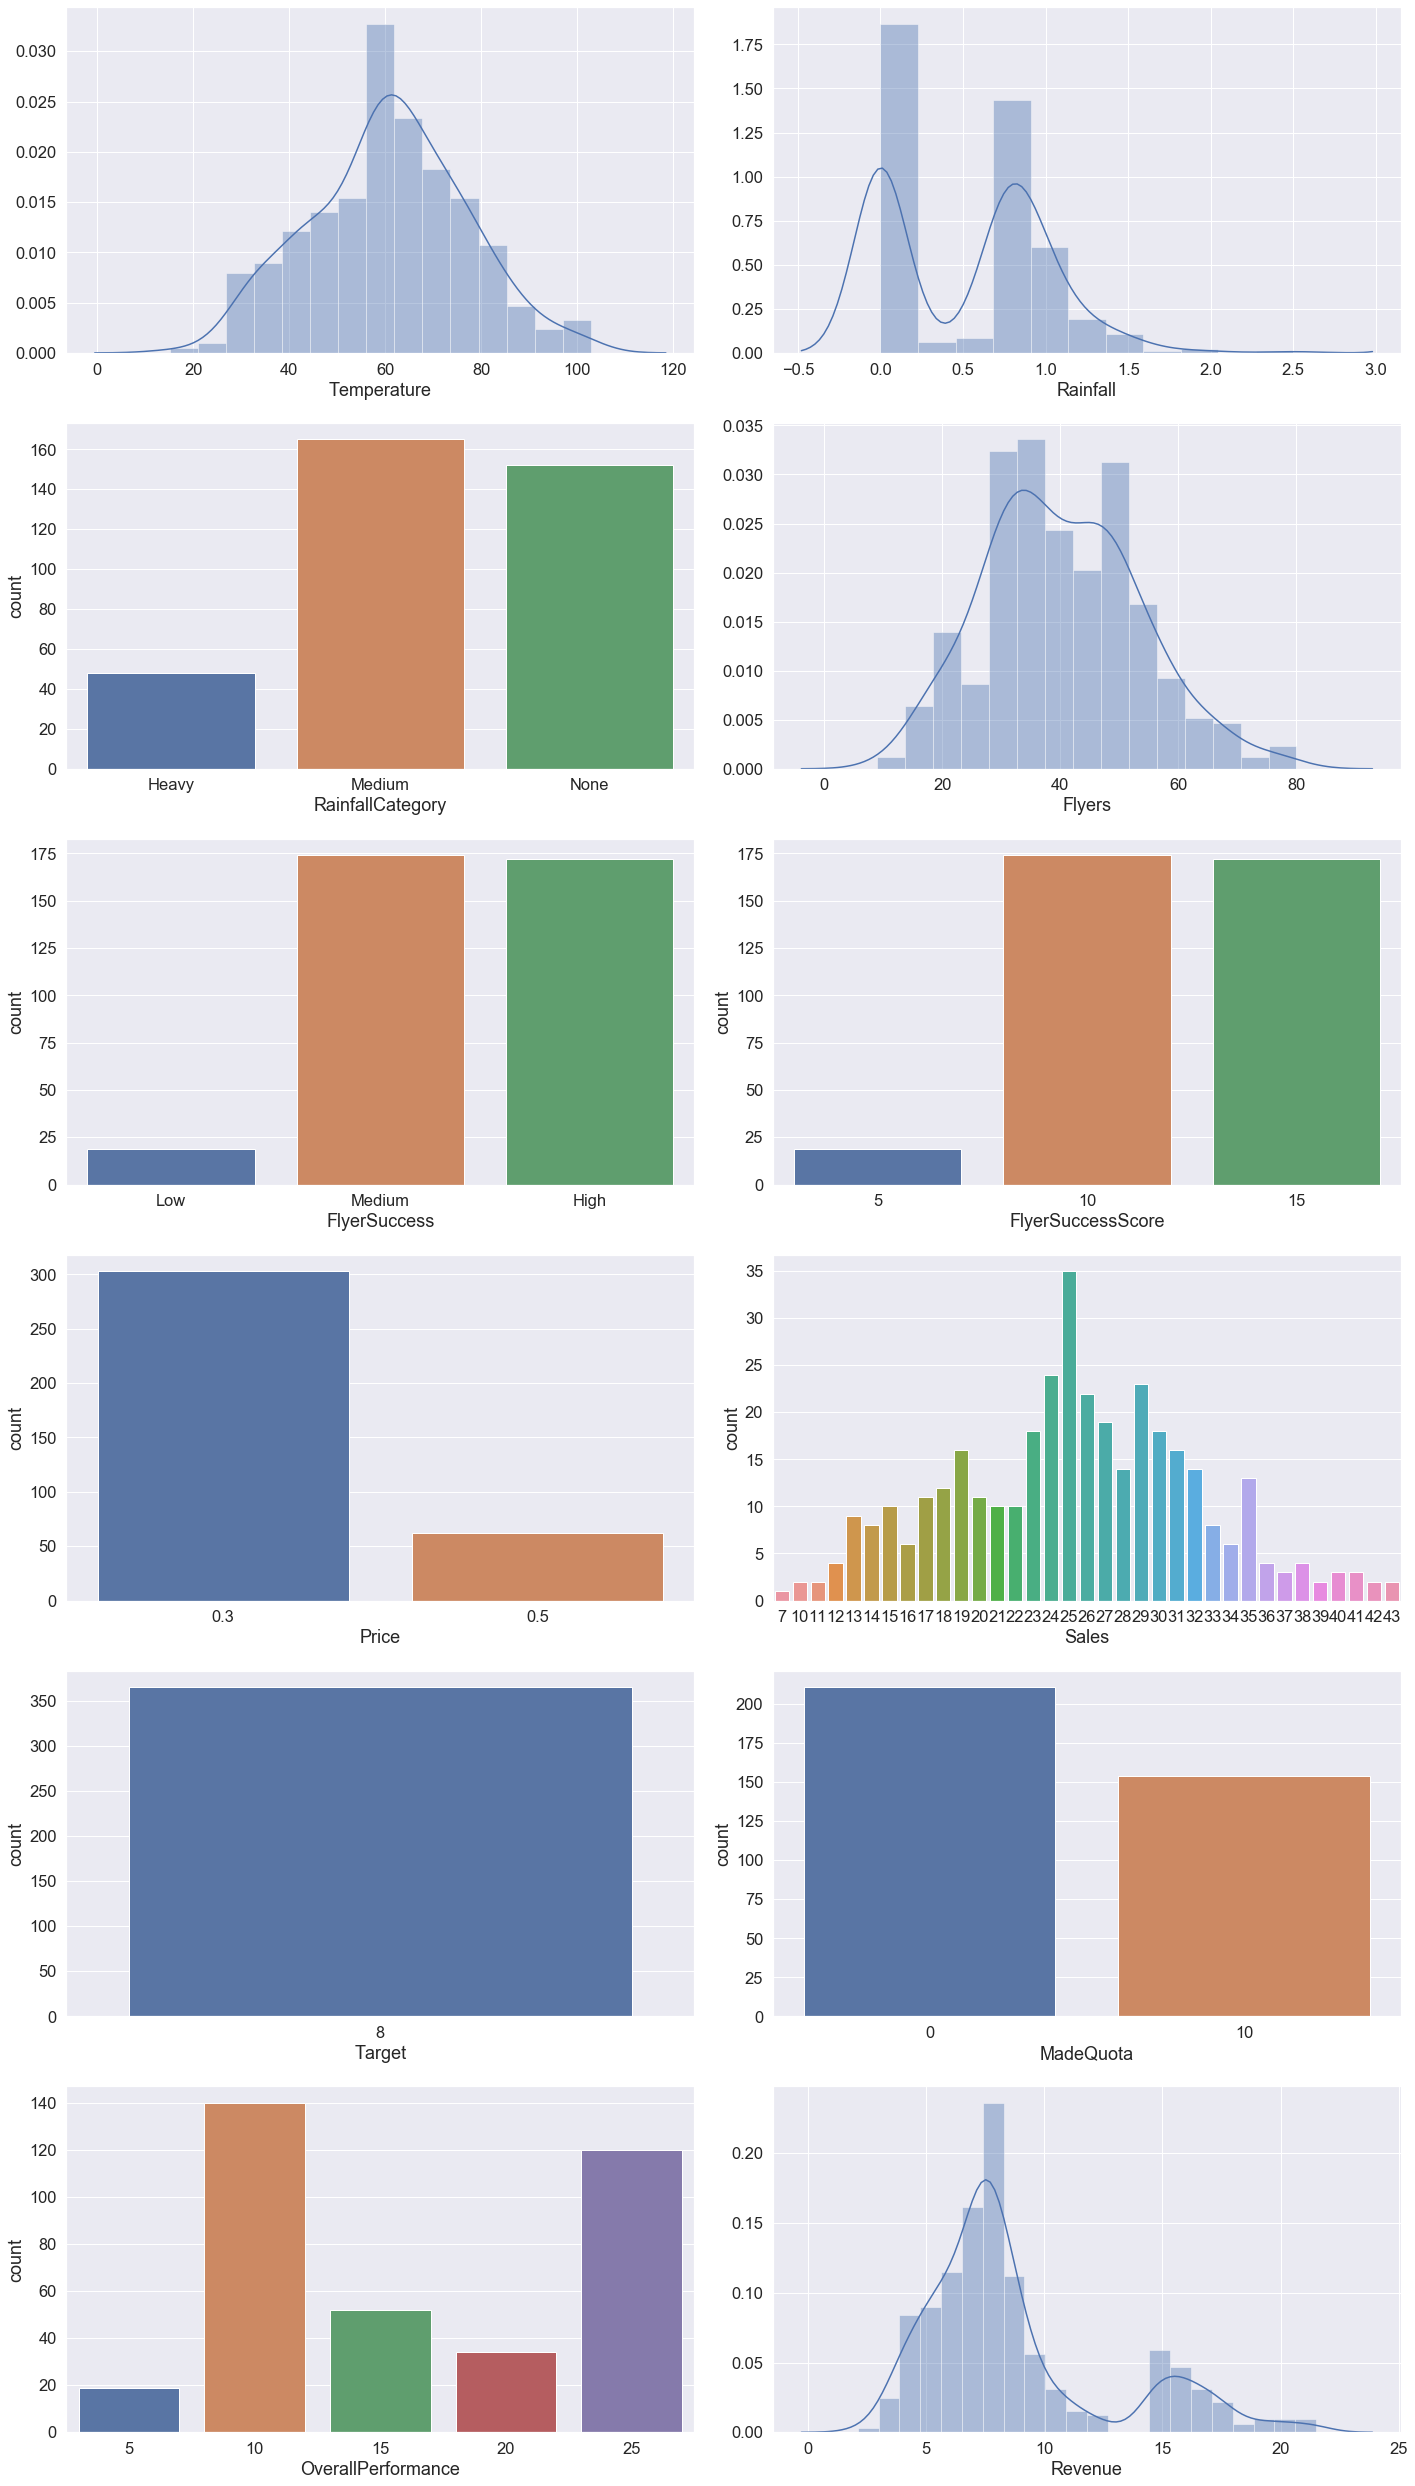

In [8]:
fig = plt.figure(figsize=(20,40))

plt.subplot(7,2,1)
sns.distplot(df.Temperature)
plt.subplot(7,2,2)
sns.distplot(df.Rainfall)
plt.subplot(7,2,3)
sns.countplot(df.RainfallCategory)
plt.subplot(7,2,4)
sns.distplot(df.Flyers)
plt.subplot(7,2,5)
sns.countplot(df.FlyerSuccess)
plt.subplot(7,2,6)
sns.countplot(df.FlyerSuccessScore)
plt.subplot(7,2,7)
sns.countplot(df.Price)
plt.subplot(7,2,8)
sns.countplot(df.Sales)
plt.subplot(7,2,9)
sns.countplot(df.Target)
plt.subplot(7,2,10)
sns.countplot(df.MadeQuota)
plt.subplot(7,2,11)
sns.countplot(df.OverallPerformance)
plt.subplot(7,2,12)
sns.distplot(df.Revenue)
# plt.subplot(7,2,13)
# sns.countplot()
# plt.subplot(7,2,14)
# sns.countplot()

plt.tight_layout()
plt.show()

### Bivariate Data Exploration

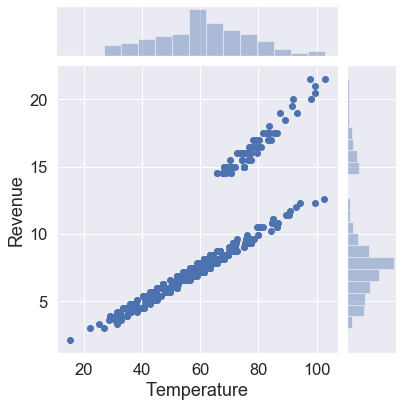

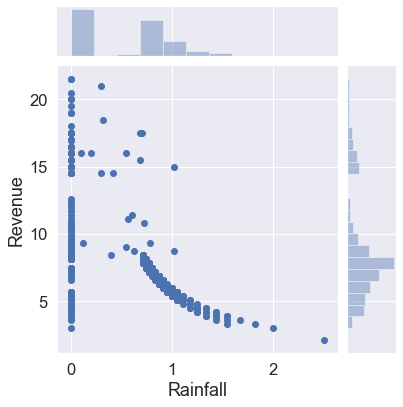

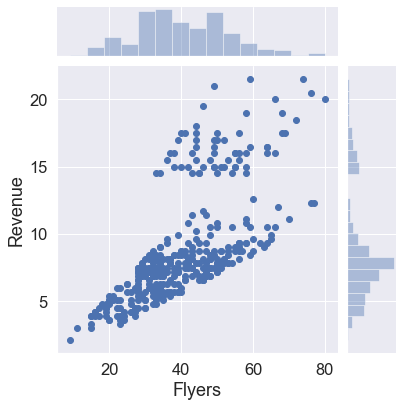

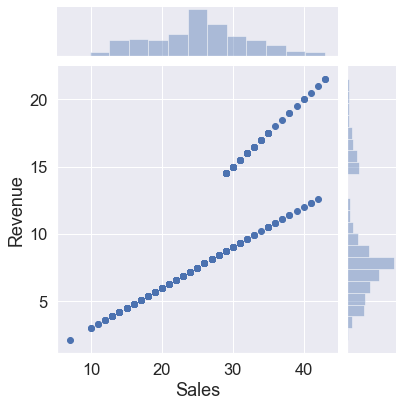

In [9]:
sns.jointplot(x='Temperature', y='Revenue',data=df, kind='scatter')

sns.jointplot(x='Rainfall', y='Revenue',data=df, kind='scatter')

sns.jointplot(x='Flyers', y='Revenue',data=df, kind='scatter')

sns.jointplot(x='Sales', y='Revenue',data=df, kind='scatter')

# sns.jointplot(x='', y='',data=df, kind='kde')

# sns.jointplot(x='', y='',data=df, kind='kde')

# sns.jointplot(x='', y='',data=df, kind='hex')

# sns.jointplot(x='', y='',data=df, kind='hex')

# sns.jointplot(x='', y='',data=df, kind='reg')

# sns.jointplot(x='', y='',data=df, kind='reg')


plt.show()

In [10]:
df.corr()

,Temperature,Rainfall,Flyers,FlyerSuccessScore,Price,Sales,Target,MadeQuota,OverallPerformance,Revenue
Temperature,1.000000,-0.637221,0.797719,0.689425,0.504709,0.989832,NaN,0.776351,0.844366,0.839314
Rainfall,-0.637221,1.000000,-0.554752,-0.517787,-0.402632,-0.642060,NaN,-0.666481,-0.693444,-0.580782
Flyers,0.797719,-0.554752,1.000000,0.853249,0.405437,0.805183,NaN,0.619692,0.802516,0.678700
FlyerSuccessScore,0.689425,-0.517787,0.853249,1.000000,0.334270,0.697682,NaN,0.521732,0.795146,0.570183
Price,0.504709,-0.402632,0.405437,0.334270,1.000000,0.512908,NaN,0.529487,0.518201,0.884179
Sales,0.989832,-0.642060,0.805183,0.697682,0.512908,1.000000,NaN,0.787478,0.855779,0.849568
Target,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MadeQuota,0.776351,-0.666481,0.619692,0.521732,0.529487,0.787478,NaN,1.000000,0.932194,0.733727
OverallPerformance,0.844366,-0.693444,0.802516,0.795146,0.518201,0.855779,NaN,0.932194,1.000000,0.763476
Revenue,0.839314,-0.580782,0.678700,0.570183,0.884179,0.849568,NaN,0.733727,0.763476,1.000000


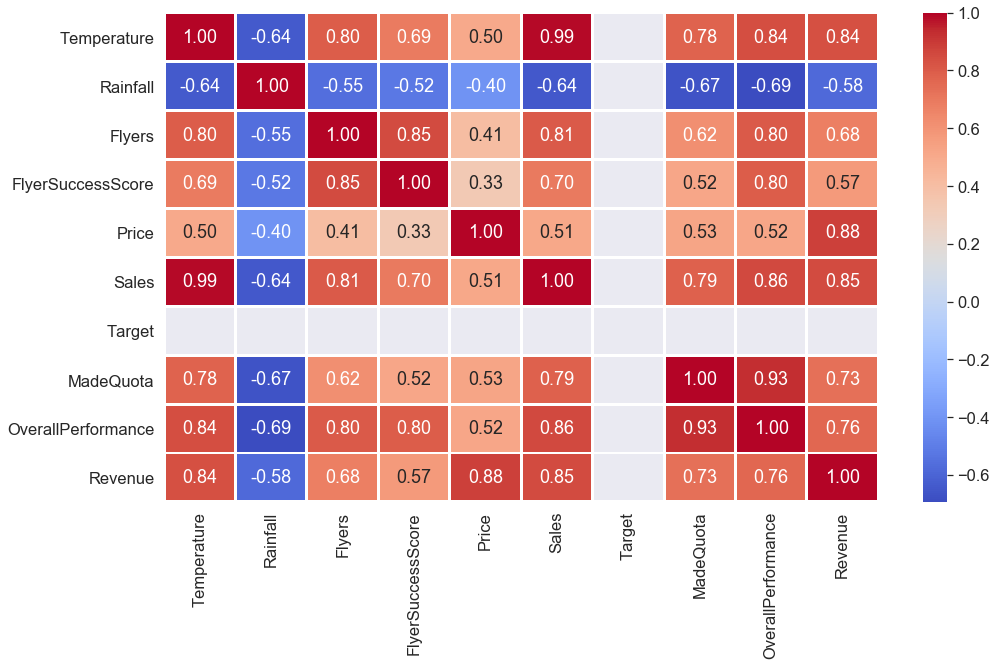

In [11]:
plt.figure(figsize=(16,9))
sns.heatmap(df.corr(),cmap="coolwarm",annot=True,fmt='.2f',linewidths=2)
plt.show()

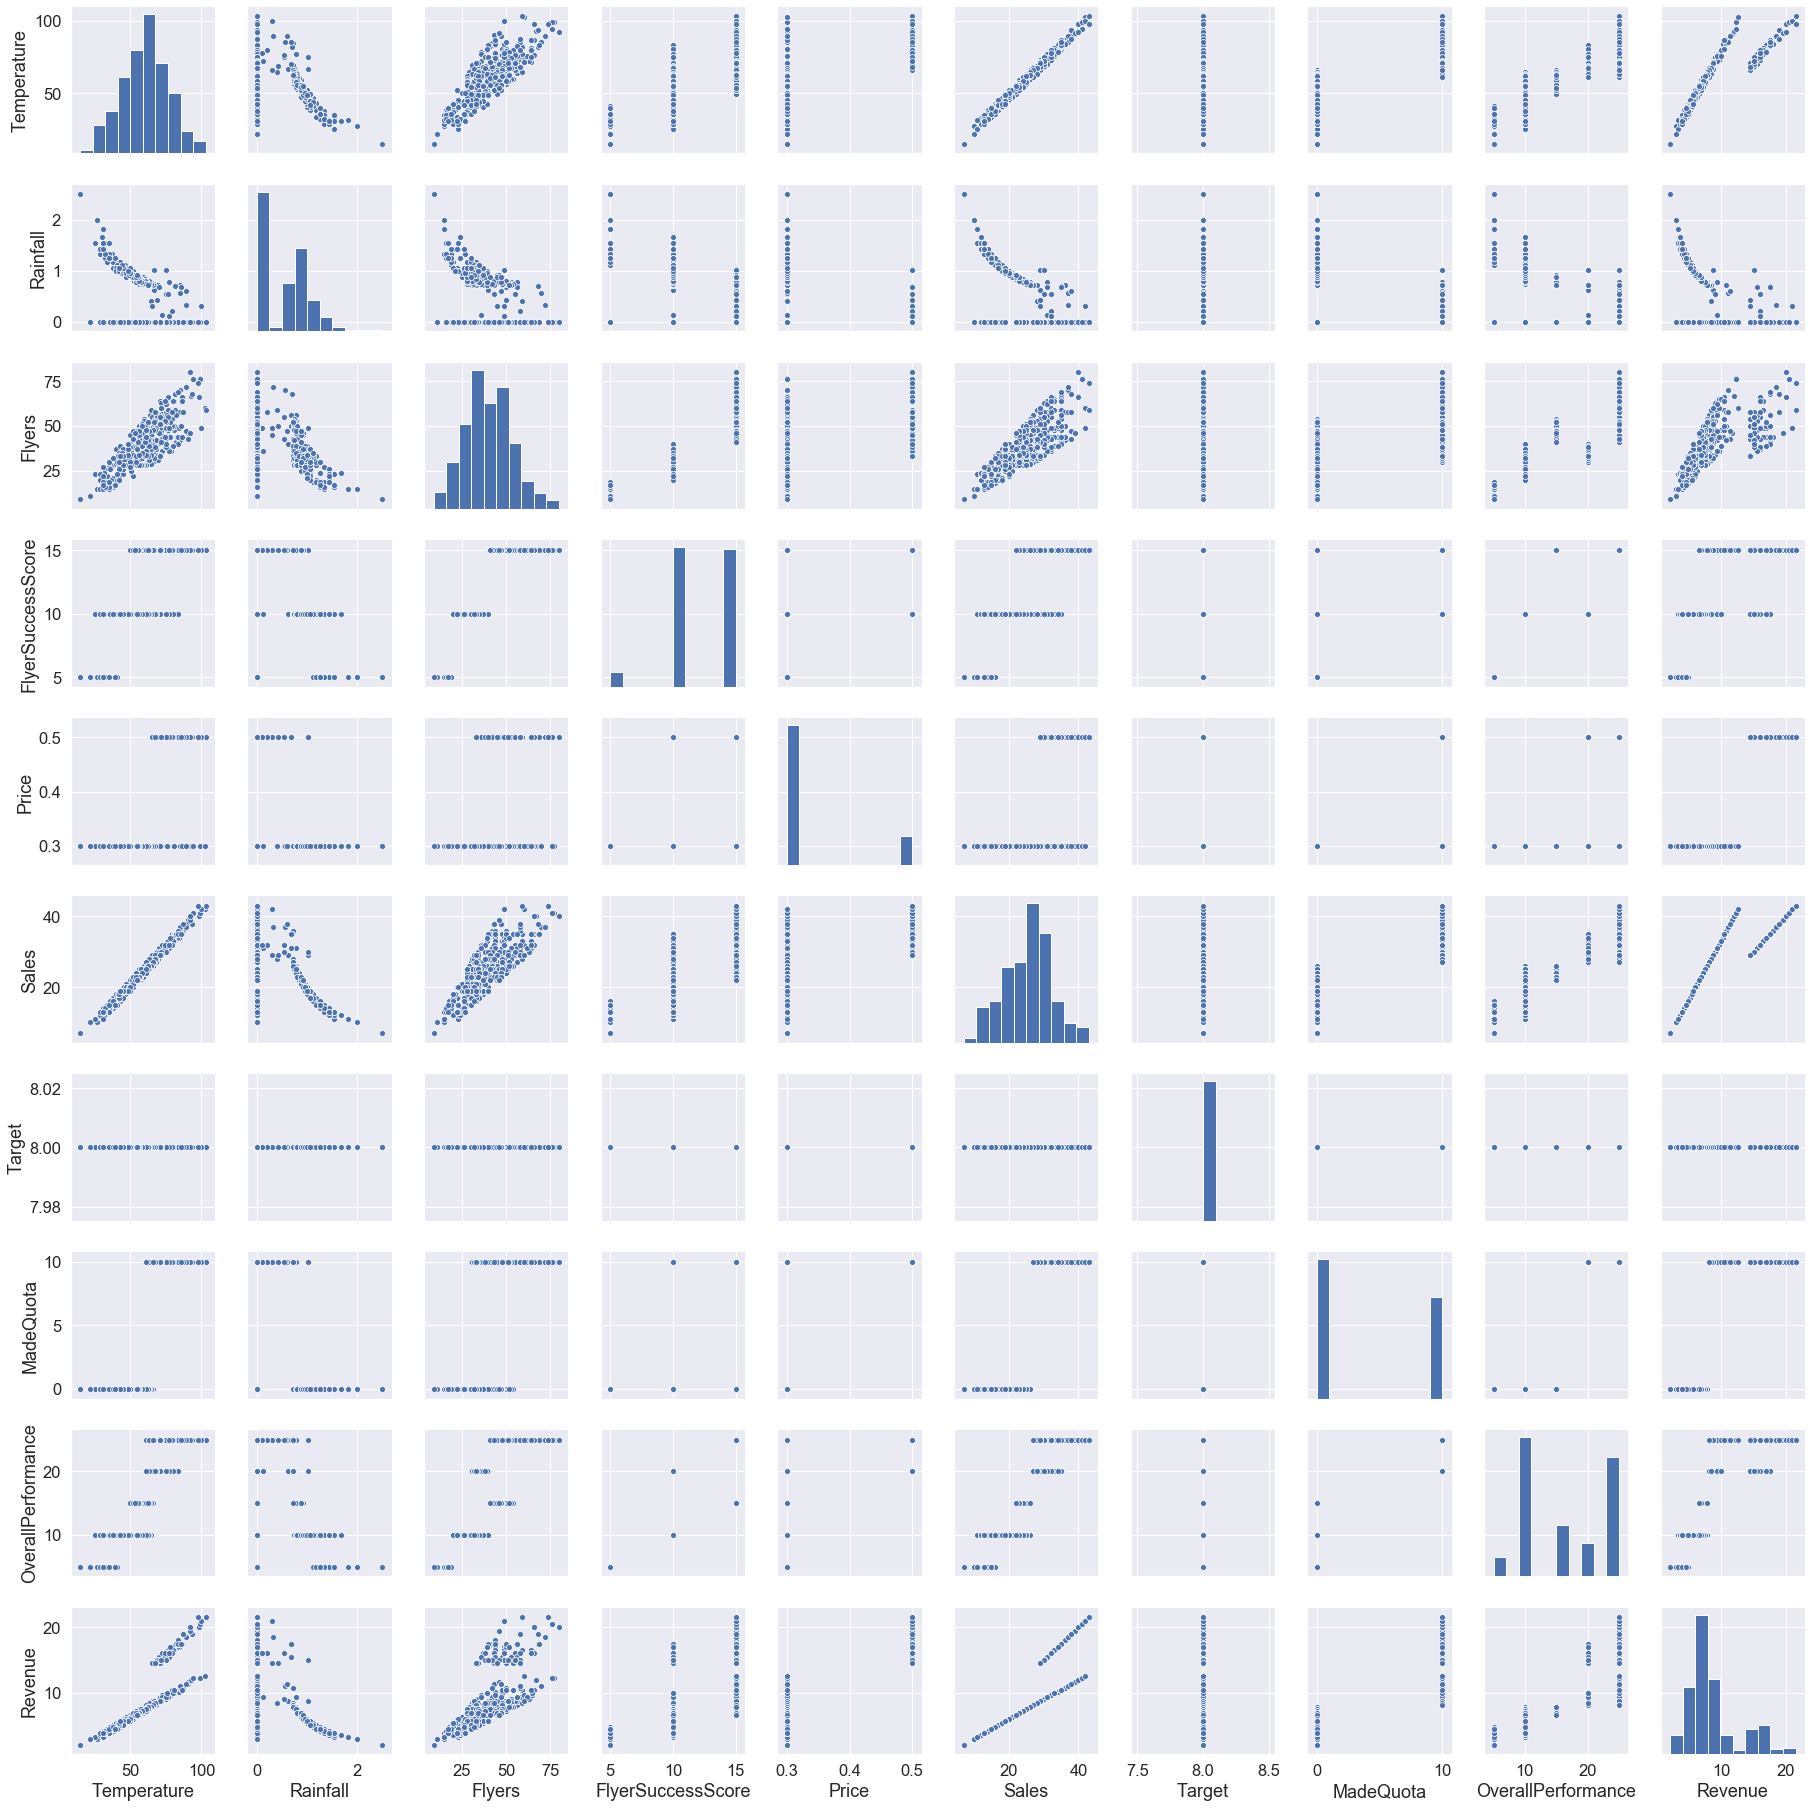

In [12]:
sns.pairplot(df)
plt.show()

### Data Preprocessing

### Treat Missing Values

In [13]:
df.isnull().sum()

Date                  0
Month                 0
Day                   0
Temperature           0
Rainfall              0
RainfallCategory      0
Flyers                0
FlyerSuccess          0
FlyerSuccessScore     0
Price                 0
Sales                 0
Target                0
MadeQuota             0
OverallPerformance    0
Revenue               0
dtype: int64

### Treat Duplicate Values

In [14]:
df.duplicated(keep='first').sum()

0

### Treat Outliers

In [15]:
df.describe()

,Temperature,Rainfall,Flyers,FlyerSuccessScore,Price,Sales,Target,MadeQuota,OverallPerformance,Revenue
count,365.000000,365.000000,365.000000,365.000000,365.000000,365.000000,365.0,365.000000,365.000000,365.000000
mean,60.731233,0.520849,40.284932,12.095890,0.333973,25.323288,8.0,4.219178,16.315068,8.722466
std,16.196266,0.490522,13.178651,2.951831,0.075206,6.893589,0.0,4.945435,6.957241,4.017536
min,15.100000,0.000000,9.000000,5.000000,0.300000,7.000000,8.0,0.000000,5.000000,2.100000
25%,49.700000,0.000000,31.000000,10.000000,0.300000,20.000000,8.0,0.000000,10.000000,6.000000
50%,61.100000,0.710000,39.000000,10.000000,0.300000,25.000000,8.0,0.000000,15.000000,7.500000
75%,71.300000,0.870000,49.000000,15.000000,0.300000,30.000000,8.0,10.000000,25.000000,9.300000
max,102.900000,2.500000,80.000000,15.000000,0.500000,43.000000,8.0,10.000000,25.000000,21.500000


### Treat Data Types

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                365 non-null    object 
 1   Month               365 non-null    object 
 2   Day                 365 non-null    object 
 3   Temperature         365 non-null    float64
 4   Rainfall            365 non-null    float64
 5   RainfallCategory    365 non-null    object 
 6   Flyers              365 non-null    int64  
 7   FlyerSuccess        365 non-null    object 
 8   FlyerSuccessScore   365 non-null    int64  
 9   Price               365 non-null    float64
 10  Sales               365 non-null    int64  
 11  Target              365 non-null    int64  
 12  MadeQuota           365 non-null    int64  
 13  OverallPerformance  365 non-null    int64  
 14  Revenue             365 non-null    float64
dtypes: float64(4), int64(6), object(5)
memory usage: 42.9+ KB

In [17]:
df['OverallPerformance'] = df['OverallPerformance'].astype('object')

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 365 entries, 0 to 364
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                365 non-null    object 
 1   Month               365 non-null    object 
 2   Day                 365 non-null    object 
 3   Temperature         365 non-null    float64
 4   Rainfall            365 non-null    float64
 5   RainfallCategory    365 non-null    object 
 6   Flyers              365 non-null    int64  
 7   FlyerSuccess        365 non-null    object 
 8   FlyerSuccessScore   365 non-null    int64  
 9   Price               365 non-null    float64
 10  Sales               365 non-null    int64  
 11  Target              365 non-null    int64  
 12  MadeQuota           365 non-null    int64  
 13  OverallPerformance  365 non-null    object 
 14  Revenue             365 non-null    float64
dtypes: float64(4), int64(5), object(6)
memory usage: 42.9+ KB

### Drop unwanted features

In [19]:
df.columns

Index(['Date', 'Month', 'Day', 'Temperature', 'Rainfall', 'RainfallCategory',
       'Flyers', 'FlyerSuccess', 'FlyerSuccessScore', 'Price', 'Sales',
       'Target', 'MadeQuota', 'OverallPerformance', 'Revenue'],
      dtype='object')

In [20]:
df.drop(['Date', 'Month', 'Day','FlyerSuccessScore', 'Price', 'Sales',
       'Target', 'MadeQuota'],axis=1,inplace=True)

In [21]:
df

,Temperature,Rainfall,RainfallCategory,Flyers,FlyerSuccess,OverallPerformance,Revenue
0,27.0,2.00,Heavy,15,Low,5,3.0
1,28.9,1.33,Heavy,15,Low,5,3.9
2,34.5,1.33,Heavy,27,Medium,10,4.5
3,44.1,1.05,Heavy,28,Medium,10,5.1
4,42.4,1.00,Medium,33,Medium,10,5.4
...,...,...,...,...,...,...,...
360,42.7,0.00,None,33,Medium,10,5.7
361,37.8,0.00,None,32,Medium,10,4.8
362,39.5,1.25,Heavy,17,Low,5,4.5
363,30.9,1.43,Heavy,22,Medium,10,3.9


In [22]:
df2 = pd.get_dummies(df,columns=['RainfallCategory','FlyerSuccess','OverallPerformance'],drop_first=True)

In [23]:
df2

,Temperature,Rainfall,Flyers,Revenue,RainfallCategory_Medium,RainfallCategory_None,FlyerSuccess_Low,FlyerSuccess_Medium,OverallPerformance_10,OverallPerformance_15,OverallPerformance_20,OverallPerformance_25
0,27.0,2.00,15,3.0,0,0,1,0,0,0,0,0
1,28.9,1.33,15,3.9,0,0,1,0,0,0,0,0
2,34.5,1.33,27,4.5,0,0,0,1,1,0,0,0
3,44.1,1.05,28,5.1,0,0,0,1,1,0,0,0
4,42.4,1.00,33,5.4,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
360,42.7,0.00,33,5.7,0,1,0,1,1,0,0,0
361,37.8,0.00,32,4.8,0,1,0,1,1,0,0,0
362,39.5,1.25,17,4.5,0,0,1,0,0,0,0,0
363,30.9,1.43,22,3.9,0,0,0,1,1,0,0,0


### Create and save processed dataset

In [24]:
df2.columns

Index(['Temperature', 'Rainfall', 'Flyers', 'Revenue',
       'RainfallCategory_Medium', 'RainfallCategory_None', 'FlyerSuccess_Low',
       'FlyerSuccess_Medium', 'OverallPerformance_10', 'OverallPerformance_15',
       'OverallPerformance_20', 'OverallPerformance_25'],
      dtype='object')

In [25]:
df2 = df2[['Temperature', 'Rainfall', 'Flyers','RainfallCategory_Medium', 'RainfallCategory_None', 'FlyerSuccess_Low',
       'FlyerSuccess_Medium', 'OverallPerformance_10', 'OverallPerformance_15',
       'OverallPerformance_20', 'OverallPerformance_25','Revenue']]

In [26]:
df2

,Temperature,Rainfall,Flyers,RainfallCategory_Medium,RainfallCategory_None,FlyerSuccess_Low,FlyerSuccess_Medium,OverallPerformance_10,OverallPerformance_15,OverallPerformance_20,OverallPerformance_25,Revenue
0,27.0,2.00,15,0,0,1,0,0,0,0,0,3.0
1,28.9,1.33,15,0,0,1,0,0,0,0,0,3.9
2,34.5,1.33,27,0,0,0,1,1,0,0,0,4.5
3,44.1,1.05,28,0,0,0,1,1,0,0,0,5.1
4,42.4,1.00,33,1,0,0,1,1,0,0,0,5.4
...,...,...,...,...,...,...,...,...,...,...,...,...
360,42.7,0.00,33,0,1,0,1,1,0,0,0,5.7
361,37.8,0.00,32,0,1,0,1,1,0,0,0,4.8
362,39.5,1.25,17,0,0,1,0,0,0,0,0,4.5
363,30.9,1.43,22,0,0,0,1,1,0,0,0,3.9


In [28]:
#df2.to_csv("lemonadetrain.csv",index=False)

In [29]:
df2.shape

(365, 12)

### Train Test Split

In [30]:
X = df2.iloc[:,0:11]
y = df2.iloc[:,11]

In [31]:
X

,Temperature,Rainfall,Flyers,RainfallCategory_Medium,RainfallCategory_None,FlyerSuccess_Low,FlyerSuccess_Medium,OverallPerformance_10,OverallPerformance_15,OverallPerformance_20,OverallPerformance_25
0,27.0,2.00,15,0,0,1,0,0,0,0,0
1,28.9,1.33,15,0,0,1,0,0,0,0,0
2,34.5,1.33,27,0,0,0,1,1,0,0,0
3,44.1,1.05,28,0,0,0,1,1,0,0,0
4,42.4,1.00,33,1,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
360,42.7,0.00,33,0,1,0,1,1,0,0,0
361,37.8,0.00,32,0,1,0,1,1,0,0,0
362,39.5,1.25,17,0,0,1,0,0,0,0,0
363,30.9,1.43,22,0,0,0,1,1,0,0,0


In [32]:
X.values, y.values

(array([[27.  ,  2.  , 15.  , ...,  0.  ,  0.  ,  0.  ],
        [28.9 ,  1.33, 15.  , ...,  0.  ,  0.  ,  0.  ],
        [34.5 ,  1.33, 27.  , ...,  0.  ,  0.  ,  0.  ],
        ...,
        [39.5 ,  1.25, 17.  , ...,  0.  ,  0.  ,  0.  ],
        [30.9 ,  1.43, 22.  , ...,  0.  ,  0.  ,  0.  ],
        [15.1 ,  2.5 ,  9.  , ...,  0.  ,  0.  ,  0.  ]]),
 array([ 3. ,  3.9,  4.5,  5.1,  5.4,  3.3,  3.9,  4.5,  5.1,  5.4,  3.6,
         4.2,  4.5,  5.1,  5.4,  3.6,  4.2,  4.8,  5.1,  3.6,  4.2,  4.8,
         5.1,  3.6,  4.2,  4.8,  5.1,  3.9,  4.2,  5.1,  5.4,  5.4,  6. ,
         6.3,  6.6,  5.4,  6. ,  6.3,  6.6,  5.7,  6. ,  6.3,  6.6,  5.4,
         5.7,  6. ,  6.3,  5.4,  5.7,  6. ,  6.3,  5.4,  5.7,  6. ,  6.3,
         5.4,  5.7,  6. ,  6.6,  6.9,  7.2,  7.2,  7.5,  6.9,  7.2,  7.2,
         7.5,  6.9,  7.2,  7.2,  7.5,  6.9,  6.9,  7.2,  7.2,  7.5,  6.9,
         6.9,  7.2,  7.2,  7.5,  6.9,  6.9,  7.2,  7.5,  7.5,  6.9,  7.2,
         7.2,  7.5,  7.5,  7.8,  7.8,  8.1,  8.4,  

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

In [34]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((292, 11), (73, 11), (292,), (73,))

### Feature Scaling

In [35]:
X_train

array([[58.5 ,  0.8 , 50.  , ...,  1.  ,  0.  ,  0.  ],
       [55.9 ,  0.87, 32.  , ...,  0.  ,  0.  ,  0.  ],
       [72.  ,  0.  , 51.  , ...,  0.  ,  0.  ,  1.  ],
       ...,
       [58.8 ,  0.74, 32.  , ...,  0.  ,  0.  ,  0.  ],
       [40.4 ,  1.  , 29.  , ...,  0.  ,  0.  ,  0.  ],
       [72.3 ,  0.12, 36.  , ...,  0.  ,  1.  ,  0.  ]])

In [36]:
minmax = MinMaxScaler()

In [37]:
X_train_scaled = minmax.fit_transform(X_train)

In [38]:
X_test_scaled = minmax.transform(X_test)

In [39]:
X_train_scaled

array([[0.49430524, 0.32      , 0.57746479, ..., 1.        , 0.        ,
        0.        ],
       [0.46469248, 0.348     , 0.32394366, ..., 0.        , 0.        ,
        0.        ],
       [0.64806378, 0.        , 0.5915493 , ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.4977221 , 0.296     , 0.32394366, ..., 0.        , 0.        ,
        0.        ],
       [0.2881549 , 0.4       , 0.28169014, ..., 0.        , 0.        ,
        0.        ],
       [0.65148064, 0.048     , 0.38028169, ..., 0.        , 1.        ,
        0.        ]])

In [40]:
X_test_scaled

array([[0.55808656, 0.284     , 0.66197183, 1.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        1.        ],
       [0.50911162, 0.284     , 0.61971831, 1.        , 0.        ,
        0.        , 0.        , 0.        , 1.        , 0.        ,
        0.        ],
       [0.42027335, 0.364     , 0.33802817, 1.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.30751708, 0.42      , 0.18309859, 0.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.49088838, 0.308     , 0.33802817, 1.        , 0.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.19476082, 0.        , 0.23943662, 0.        , 1.        ,
        0.        , 1.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.48291572, 0.32      , 0.33802817, 1.        , 0.

### Model Training

### Using XGBoost (Scikit-Learn)

In [41]:
xgbmodel = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [42]:
xgbmodel.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:8.24449
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.49255
[2]	validation_0-rmse:6.8365
[3]	validation_0-rmse:6.2258
[4]	validation_0-rmse:5.68725
[5]	validation_0-rmse:5.2163
[6]	validation_0-rmse:4.78247
[7]	validation_0-rmse:4.40526
[8]	validation_0-rmse:4.06894
[9]	validation_0-rmse:3.78046
[10]	validation_0-rmse:3.52139
[11]	validation_0-rmse:3.27058
[12]	validation_0-rmse:3.07878
[13]	validation_0-rmse:2.89319
[14]	validation_0-rmse:2.75067
[15]	validation_0-rmse:2.61379
[16]	validation_0-rmse:2.48927
[17]	validation_0-rmse:2.37851
[18]	validation_0-rmse:2.30081
[19]	validation_0-rmse:2.23443
[20]	validation_0-rmse:2.17754
[21]	validation_0-rmse:2.12302
[22]	validation_0-rmse:2.0801
[23]	validation_0-rmse:2.04981
[24]	validation_0-rmse:2.01762
[25]	validation_0-rmse:2.00054
[26]	validation_0-rmse:1.97687
[27]	validation_0-rmse:1.96792
[28]	validation_0-rmse:1.95104
[29]	validation_0-rmse:1.94637
[30]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [43]:
y_pred = xgbmodel.predict(X_test_scaled)

In [44]:
y_pred

array([ 8.810781 ,  7.3875256,  6.392755 ,  5.0673003,  7.177376 ,
        4.1723866,  7.156735 ,  5.6785407, 13.2274275,  4.1261406,
       10.05174  , 11.02432  ,  7.3875256,  7.250024 ,  7.550061 ,
       13.092275 ,  7.177376 ,  8.452859 , 11.676963 , 10.335032 ,
       11.531085 , 14.007871 ,  7.097653 ,  6.971526 ,  7.17001  ,
        7.425528 ,  7.170301 ,  5.906788 ,  8.292204 , 14.123199 ,
       10.047669 ,  7.980445 ,  3.9026387,  6.392755 ,  5.856251 ,
        3.47746  ,  7.0306077, 10.696263 ,  7.506481 ,  7.2880263,
       13.386472 ,  6.7352705, 10.93319  ,  7.643983 ,  4.599657 ,
        6.7208486, 11.426739 , 12.26145  , 12.481125 ,  7.250024 ,
       14.123199 , 13.028889 , 12.010005 , 13.903524 ,  7.2880263,
        5.2798686,  5.856251 ,  9.817579 ,  7.250024 ,  6.7208486,
        6.392755 ,  8.590361 ,  4.7002296,  7.2880263,  6.7352705,
        3.953991 ,  5.7320247, 11.737384 , 10.603334 , 13.196621 ,
        7.170301 , 15.9484825,  7.643983 ], dtype=float32)

### Model Evaluation

In [45]:
mse = mean_squared_error(y_test,y_pred)
mse

3.6416178490327527

In [46]:
rmse = np.sqrt(mse)
rmse

1.9083023473843848

In [47]:
r2score = r2_score(y_test,y_pred)
r2score

0.7347956264852107

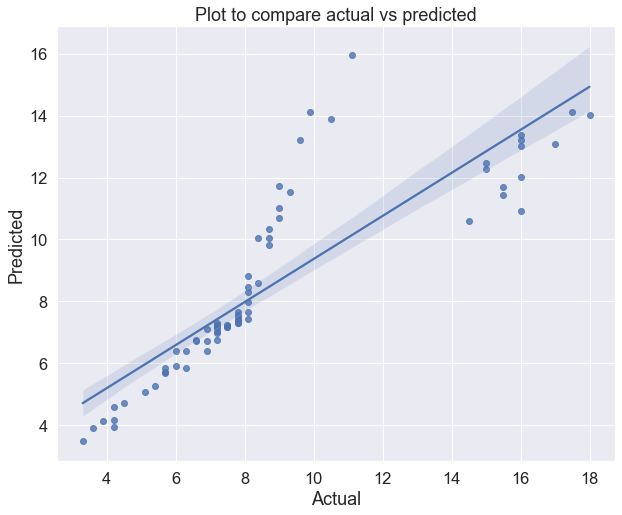

In [48]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Available importance_types = [‘weight’, ‘gain’, ‘cover’, ‘total_gain’, ‘total_cover’]

In [49]:
X.columns

Index(['Temperature', 'Rainfall', 'Flyers', 'RainfallCategory_Medium',
       'RainfallCategory_None', 'FlyerSuccess_Low', 'FlyerSuccess_Medium',
       'OverallPerformance_10', 'OverallPerformance_15',
       'OverallPerformance_20', 'OverallPerformance_25'],
      dtype='object')

In [50]:
xgbmodel.get_booster().feature_names = ['Temperature', 'Rainfall', 'Flyers', 'RainfallCategory_Medium',
       'RainfallCategory_None', 'FlyerSuccess_Low', 'FlyerSuccess_Medium',
       'OverallPerformance_10', 'OverallPerformance_15',
       'OverallPerformance_20', 'OverallPerformance_25']

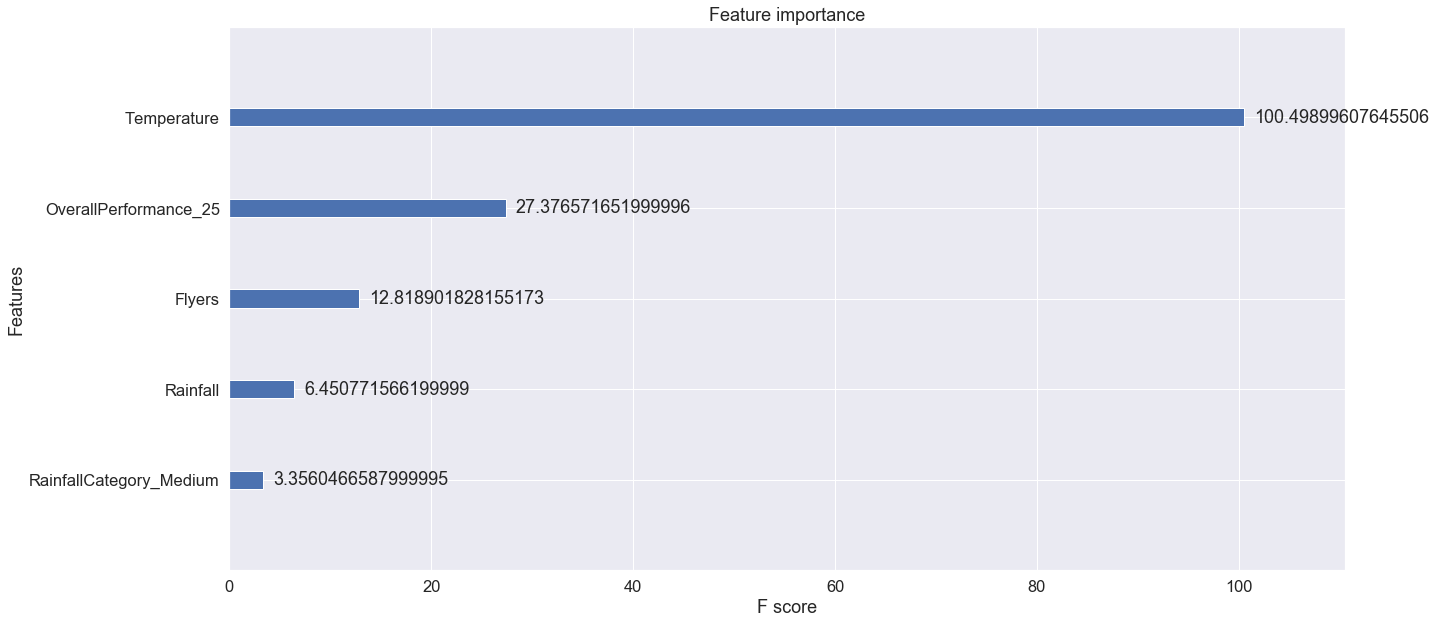

In [51]:
fig, ax = plt.subplots(figsize=(20,10))
xgb.plot_importance(xgbmodel.get_booster(),ax=ax,importance_type='gain')
plt.show()

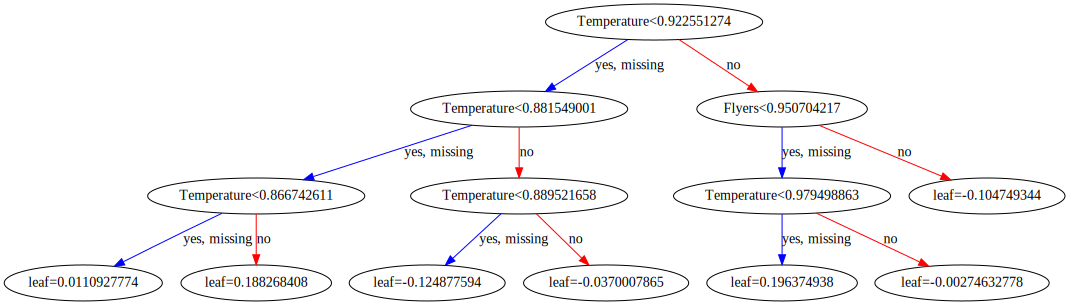

In [52]:
xgb.to_graphviz(xgbmodel,num_trees=40)

### Cross-Validation

In [53]:
cv = cross_val_score(xgbmodel,X_train_scaled,y_train,cv=5,verbose=1,scoring='r2')

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished


In [54]:
cv.mean()

0.6802209128749159

### Feature Selection

In [55]:
df2.columns

Index(['Temperature', 'Rainfall', 'Flyers', 'RainfallCategory_Medium',
       'RainfallCategory_None', 'FlyerSuccess_Low', 'FlyerSuccess_Medium',
       'OverallPerformance_10', 'OverallPerformance_15',
       'OverallPerformance_20', 'OverallPerformance_25', 'Revenue'],
      dtype='object')

In [56]:
df3 = df2[['Temperature', 'Rainfall', 'Flyers','RainfallCategory_Medium','OverallPerformance_25', 'Revenue']]

In [57]:
df3

,Temperature,Rainfall,Flyers,RainfallCategory_Medium,OverallPerformance_25,Revenue
0,27.0,2.00,15,0,0,3.0
1,28.9,1.33,15,0,0,3.9
2,34.5,1.33,27,0,0,4.5
3,44.1,1.05,28,0,0,5.1
4,42.4,1.00,33,1,0,5.4
...,...,...,...,...,...,...
360,42.7,0.00,33,0,0,5.7
361,37.8,0.00,32,0,0,4.8
362,39.5,1.25,17,0,0,4.5
363,30.9,1.43,22,0,0,3.9


In [58]:
X = df3.iloc[:,0:5]
y = df3.iloc[:,5]

In [59]:
X.values, y.values

(array([[27.  ,  2.  , 15.  ,  0.  ,  0.  ],
        [28.9 ,  1.33, 15.  ,  0.  ,  0.  ],
        [34.5 ,  1.33, 27.  ,  0.  ,  0.  ],
        ...,
        [39.5 ,  1.25, 17.  ,  0.  ,  0.  ],
        [30.9 ,  1.43, 22.  ,  0.  ,  0.  ],
        [15.1 ,  2.5 ,  9.  ,  0.  ,  0.  ]]),
 array([ 3. ,  3.9,  4.5,  5.1,  5.4,  3.3,  3.9,  4.5,  5.1,  5.4,  3.6,
         4.2,  4.5,  5.1,  5.4,  3.6,  4.2,  4.8,  5.1,  3.6,  4.2,  4.8,
         5.1,  3.6,  4.2,  4.8,  5.1,  3.9,  4.2,  5.1,  5.4,  5.4,  6. ,
         6.3,  6.6,  5.4,  6. ,  6.3,  6.6,  5.7,  6. ,  6.3,  6.6,  5.4,
         5.7,  6. ,  6.3,  5.4,  5.7,  6. ,  6.3,  5.4,  5.7,  6. ,  6.3,
         5.4,  5.7,  6. ,  6.6,  6.9,  7.2,  7.2,  7.5,  6.9,  7.2,  7.2,
         7.5,  6.9,  7.2,  7.2,  7.5,  6.9,  6.9,  7.2,  7.2,  7.5,  6.9,
         6.9,  7.2,  7.2,  7.5,  6.9,  6.9,  7.2,  7.5,  7.5,  6.9,  7.2,
         7.2,  7.5,  7.5,  7.8,  7.8,  8.1,  8.4,  7.5,  7.8,  7.8,  8.1,
         7.5,  7.8,  8.1,  8.1,  7.5,  7.8,  8.1,

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.2, random_state=0)

In [61]:
X_train

array([[58.5 ,  0.8 , 50.  ,  1.  ,  0.  ],
       [55.9 ,  0.87, 32.  ,  1.  ,  0.  ],
       [72.  ,  0.  , 51.  ,  0.  ,  1.  ],
       ...,
       [58.8 ,  0.74, 32.  ,  1.  ,  0.  ],
       [40.4 ,  1.  , 29.  ,  1.  ,  0.  ],
       [72.3 ,  0.12, 36.  ,  1.  ,  0.  ]])

In [62]:
minmax = MinMaxScaler()

In [63]:
X_train_scaled = minmax.fit_transform(X_train)

In [64]:
X_test_scaled = minmax.transform(X_test)

In [65]:
X_train_scaled

array([[0.49430524, 0.32      , 0.57746479, 1.        , 0.        ],
       [0.46469248, 0.348     , 0.32394366, 1.        , 0.        ],
       [0.64806378, 0.        , 0.5915493 , 0.        , 1.        ],
       ...,
       [0.4977221 , 0.296     , 0.32394366, 1.        , 0.        ],
       [0.2881549 , 0.4       , 0.28169014, 1.        , 0.        ],
       [0.65148064, 0.048     , 0.38028169, 1.        , 0.        ]])

In [66]:
X_test_scaled

array([[0.55808656, 0.284     , 0.66197183, 1.        , 1.        ],
       [0.50911162, 0.284     , 0.61971831, 1.        , 0.        ],
       [0.42027335, 0.364     , 0.33802817, 1.        , 0.        ],
       [0.30751708, 0.42      , 0.18309859, 0.        , 0.        ],
       [0.49088838, 0.308     , 0.33802817, 1.        , 0.        ],
       [0.19476082, 0.        , 0.23943662, 0.        , 0.        ],
       [0.48291572, 0.32      , 0.33802817, 1.        , 0.        ],
       [0.33712984, 0.38      , 0.3943662 , 1.        , 0.        ],
       [0.7118451 , 0.04      , 0.56338028, 1.        , 1.        ],
       [0.20273349, 0.        , 0.14084507, 0.        , 0.        ],
       [0.58769932, 0.        , 0.66197183, 0.        , 1.        ],
       [0.63667426, 0.        , 0.35211268, 0.        , 0.        ],
       [0.50911162, 0.284     , 0.46478873, 1.        , 0.        ],
       [0.50569476, 0.296     , 0.26760563, 1.        , 0.        ],
       [0.54328018, 0.284     , 0.

In [67]:
xgbmodel2 = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [68]:
xgbmodel2.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:8.24449
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.49255
[2]	validation_0-rmse:6.8365
[3]	validation_0-rmse:6.2258
[4]	validation_0-rmse:5.68725
[5]	validation_0-rmse:5.2163
[6]	validation_0-rmse:4.78247
[7]	validation_0-rmse:4.40526
[8]	validation_0-rmse:4.06894
[9]	validation_0-rmse:3.78046
[10]	validation_0-rmse:3.52139
[11]	validation_0-rmse:3.27058
[12]	validation_0-rmse:3.07878
[13]	validation_0-rmse:2.89319
[14]	validation_0-rmse:2.75067
[15]	validation_0-rmse:2.61379
[16]	validation_0-rmse:2.48927
[17]	validation_0-rmse:2.37851
[18]	validation_0-rmse:2.30081
[19]	validation_0-rmse:2.23443
[20]	validation_0-rmse:2.17754
[21]	validation_0-rmse:2.12302
[22]	validation_0-rmse:2.0801
[23]	validation_0-rmse:2.04981
[24]	validation_0-rmse:2.01762
[25]	validation_0-rmse:2.00054
[26]	validation_0-rmse:1.97687
[27]	validation_0-rmse:1.96792
[28]	validation_0-rmse:1.95104
[29]	validation_0-rmse:1.94637
[30]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:squarederror',
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             seed=None, silent=None, subsample=1, verbosity=1)

In [69]:
y_pred = xgbmodel2.predict(X_test_scaled)

In [70]:
y_pred

array([ 8.810781 ,  7.3875256,  6.392755 ,  5.0673003,  7.177376 ,
        4.1723866,  7.156735 ,  5.6785407, 13.2274275,  4.1261406,
       10.05174  , 11.02432  ,  7.3875256,  7.250024 ,  7.550061 ,
       13.092275 ,  7.177376 ,  8.452859 , 11.676963 , 10.335032 ,
       11.531085 , 14.007871 ,  7.097653 ,  6.971526 ,  7.17001  ,
        7.425528 ,  7.170301 ,  5.906788 ,  8.292204 , 14.123199 ,
       10.047669 ,  7.980445 ,  3.9026387,  6.392755 ,  5.856251 ,
        3.47746  ,  7.0306077, 10.696263 ,  7.506481 ,  7.2880263,
       13.386472 ,  6.7352705, 10.93319  ,  7.643983 ,  4.599657 ,
        6.7208486, 11.426739 , 12.26145  , 12.481125 ,  7.250024 ,
       14.123199 , 13.028889 , 12.010005 , 13.903524 ,  7.2880263,
        5.2798686,  5.856251 ,  9.817579 ,  7.250024 ,  6.7208486,
        6.392755 ,  8.590361 ,  4.7002296,  7.2880263,  6.7352705,
        3.953991 ,  5.7320247, 11.737384 , 10.603334 , 13.196621 ,
        7.170301 , 15.9484825,  7.643983 ], dtype=float32)

In [71]:
mse = mean_squared_error(y_test,y_pred)
mse

3.6416178490327527

In [72]:
rmse = np.sqrt(mse)
rmse

1.9083023473843848

In [73]:
r2score = r2_score(y_test,y_pred)
r2score

0.7347956264852107

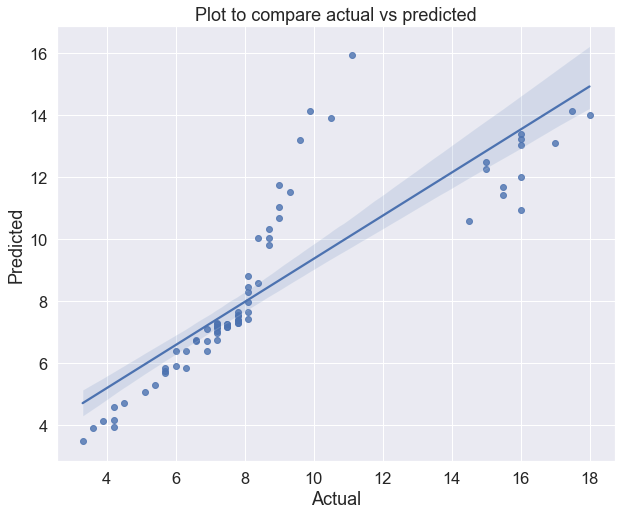

In [74]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Model Tuning

### Using RandomSearchCV

In [75]:
model = XGBRegressor(random_state=0, n_estimators=100, objective='reg:squarederror')

In [76]:
parameters = {'max_depth': np.arange(3,10,1),
              'learning rate': np.arange(0.05,0.3,0.03),
              'n_estimators':np.arange(100,1000,100),
              'min_child_weight': np.arange(1,4,1),
              'gamma':np.arange(0,50,2),
              'subsample':np.arange(0.5,0.9,0.1),
              'colsample_bytree':np.arange(0.5,0.9,0.1)
             }

In [77]:
randm = RandomizedSearchCV(estimator=model, param_distributions = parameters, cv = 5, n_iter = 50, 
                           n_jobs=-1, scoring='r2')

In [78]:
randm.fit(X_train_scaled, y_train)

RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.1, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=100,
                                          n_jobs=1, nthread=None,
                                          objective='reg:squarederror',
                                          random_state=0, reg_...
       34, 36, 38, 40, 42, 44, 46, 48]),
                                        'learning rate': array([0.05, 0.08, 0.11, 0.14, 0.17, 0.2 , 0.23, 0.26, 0.29]),
                           

In [79]:
randm.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=32,
             importance_type='gain', learning rate=0.16999999999999998,
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=2, missing=None, n_estimators=500, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [80]:
randm.best_score_

0.7142441106434407

In [81]:
randm.best_params_

{'subsample': 0.7,
 'n_estimators': 500,
 'min_child_weight': 2,
 'max_depth': 4,
 'learning rate': 0.16999999999999998,
 'gamma': 32,
 'colsample_bytree': 0.5}

### Final Model

In [82]:
xgbnew = randm.best_estimator_

In [83]:
xgbnew.fit(X_train_scaled,y_train,eval_set=[(X_test_scaled,y_test)],eval_metric='rmse',early_stopping_rounds=10)

[0]	validation_0-rmse:8.2823
Will train until validation_0-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:7.5439
[2]	validation_0-rmse:6.86679
[3]	validation_0-rmse:6.31256
[4]	validation_0-rmse:5.82929
[5]	validation_0-rmse:5.31154
[6]	validation_0-rmse:4.85195
[7]	validation_0-rmse:4.45165
[8]	validation_0-rmse:4.16165
[9]	validation_0-rmse:3.87912
[10]	validation_0-rmse:3.63128
[11]	validation_0-rmse:3.41445
[12]	validation_0-rmse:3.2058
[13]	validation_0-rmse:3.06825
[14]	validation_0-rmse:2.95269
[15]	validation_0-rmse:2.80287
[16]	validation_0-rmse:2.69879
[17]	validation_0-rmse:2.58629
[18]	validation_0-rmse:2.50024
[19]	validation_0-rmse:2.40079
[20]	validation_0-rmse:2.35108
[21]	validation_0-rmse:2.29314
[22]	validation_0-rmse:2.24689
[23]	validation_0-rmse:2.20831
[24]	validation_0-rmse:2.16909
[25]	validation_0-rmse:2.14703
[26]	validation_0-rmse:2.1308
[27]	validation_0-rmse:2.11798
[28]	validation_0-rmse:2.10379
[29]	validation_0-rmse:2.08494
[30]	validation_0-r

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.5, gamma=32,
             importance_type='gain', learning rate=0.16999999999999998,
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=2, missing=None, n_estimators=500, n_jobs=1,
             nthread=None, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=0.7, verbosity=1)

In [84]:
y_pred = xgbnew.predict(X_test_scaled)

In [85]:
y_pred

array([ 8.527186 ,  7.4582114,  6.6139407,  4.5648847,  7.054473 ,
        5.3446116,  7.054473 ,  6.196321 , 14.178309 ,  5.3446116,
        9.923136 , 10.05699  ,  7.4752874,  6.959221 ,  7.4582114,
       13.761452 ,  7.1819844,  7.3288007, 11.794171 , 10.773367 ,
       12.998276 , 14.1230545,  7.2581415,  6.774187 ,  7.7501154,
        7.415668 ,  7.013649 ,  5.29397  ,  9.640104 , 12.984377 ,
        8.667873 ,  9.996465 ,  4.2127337,  6.798813 ,  6.196321 ,
        4.2127337,  7.054473 ,  9.743939 ,  7.289507 ,  6.959221 ,
       12.066181 ,  8.048822 , 11.947832 ,  7.5231905,  4.2127337,
        7.057239 , 12.534392 , 12.500689 , 11.482897 ,  7.054473 ,
       13.127855 , 13.132638 , 11.887686 , 13.806076 ,  7.2818894,
        4.921797 ,  6.196321 , 10.630838 ,  7.2989655,  6.812747 ,
        6.858433 ,  8.932903 ,  5.124363 ,  7.1819844,  8.63799  ,
        4.2127337,  5.6545362, 12.133064 , 11.362544 , 13.679781 ,
        7.198521 , 15.874496 ,  7.5231905], dtype=float32)

In [86]:
r2score = r2_score(y_test,y_pred)
r2score

0.7250730207365166

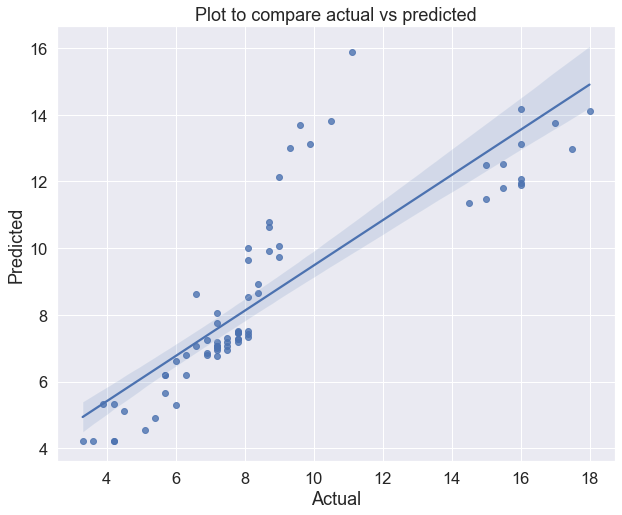

In [87]:
fig, ax = plt.subplots(figsize=(10,8))
sns.regplot(x=y_test, y=y_pred, ax=ax)
plt.title("Plot to compare actual vs predicted")
plt.ylabel("Predicted")
plt.xlabel("Actual")
plt.show()

### Save the Model

In [88]:
filename = 'modellemonade.sav'
dump(xgbnew,open(filename,'wb'))